# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Add any additional import statements you need here

sw = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize

nltk.download('punkt')

punctuation = set(punctuation)
tw_punct = punctuation - {"#"}

def remove_stop(tokens):
    """
    Remove stop words from a list of tokens.

    Args:
        tokens (list): List of tokens.

    Returns:
        list: List of tokens with stop words removed.
    """
    filtered_tokens = [word for word in tokens if word.lower() not in sw]
    return filtered_tokens


def remove_punctuation(text, punct_set=tw_punct) :
    return("".join([ch for ch in text if ch not in punct_set]))


def tokenize(text):
    """
    Split text on whitespace and return tokens.

    Args:
        text (str): Input text.

    Returns:
        list: List of tokens.
    """
    tokens = text.split()

    return tokens

def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/content/drive/MyDrive"

# These subfolders should still work if you correctly stored the
# data from the Module 1 assignment
twitter_folder = "/content/drive/MyDrive/twitter"
lyrics_folder = "/content/drive/MyDrive/lyrics"

positive_words_file = "/content/positive-words.txt"
negative_words_file = "/content/negative-words.txt"
tidy_text_file = "/content/tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.




In [4]:

def process_lyrics_files_in_subfolders(folder_path):
    data_list = []
    for artist_folder in os.listdir(folder_path):
        artist_path = os.path.join(folder_path, artist_folder)
        if os.path.isdir(artist_path):
            for filename in os.listdir(artist_path):
                if filename.endswith('.txt'):
                    file_path = os.path.join(artist_path, filename)
                    with open(file_path, 'r') as file:
                        lyrics = file.read()
                        data_list.append({'Artist': artist_folder, 'Song': filename.replace('.txt', ''), 'Lyrics': lyrics})
    return data_list

# Get lyrics data from the specified Google Drive folder
lyrics_data = process_lyrics_files_in_subfolders(lyrics_folder)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(lyrics_data)

# Display the DataFrame
df.head()



,Artist,Song,Lyrics
0,cher,cher_borrowedtime,"""Borrowed Time""\n\n\n\nI turn my back on him\n..."
1,cher,cher_mylove,"""My Love""\n\n\n\nWhen I go away\nI know my hea..."
2,cher,cher_reasontobelieve,"""Reason To Believe""\n\n\n\nIf I listen long en..."
3,cher,cher_dovelamore,"""Dov'e L'Amore""\n\n\n\nDov'e se adesso\nDov'e ..."
4,cher,cher_stillinlovewithyou,"""Still In Love With You""\n\n\n\nVisions haunt ..."


In [5]:


def process_twitter_files_in_subfolders(parent_folder_path):
    data_list = []
    for artist_folder in os.listdir(parent_folder_path):
        artist_path = os.path.join(parent_folder_path, artist_folder)
        if os.path.isdir(artist_path):
            for filename in os.listdir(artist_path):
                if filename.endswith('.txt'):
                    file_path = os.path.join(artist_path, filename)
                    with open(file_path, 'r', encoding='utf-8') as file:
                        lines = file.readlines()
                        column_names = lines[0].strip().split('\t')  # First row contains column names separated by tabs
                        for line in lines[1:]:
                            values = line.strip().split('\t')  # Split tab-separated values
                            data_dict = {'Artist': artist_folder}
                            for column, value in zip(column_names, values):
                                data_dict[column] = value
                            data_list.append(data_dict)
    return data_list

# Get Twitter data
twitter_data = process_twitter_files_in_subfolders(twitter_folder)

# Create a DataFrame from the list of dictionaries
twitter_df = pd.DataFrame(twitter_data)

# Display the DataFrame
twitter_df.head()


,Artist,screen_name,name,id,location,followers_count,friends_count,description
0,cher,hsmcnp,Country Girl,35152213,,1302,1014,NaN
1,cher,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,cher,anju79990584,anju,1496463006451974150,,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,cher,gallionjenna,J,3366479914,,752,556,csu
4,cher,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...


In [6]:
columns_to_keep = ['description', 'Artist']

# Keep only the specified columns
twitter_df = twitter_df[columns_to_keep]

In [9]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a
# dictionary for this.


with open(positive_words_file, 'r') as file:
    positive_words = file.read().splitlines()

positive_word_scores = {word: 1 for word in positive_words}

with open(negative_words_file, 'r') as file:
    negative_words = file.read().splitlines()

negative_word_scores = {word: -1 for word in negative_words}

tidytext_sentiment = {
    "good": 1,
    "bad": -1,
    # ... other words and scores
}

# Merge positive, negative and tidytext
word_scores = {}
word_scores.update(positive_word_scores)
word_scores.update(negative_word_scores)
word_scores.update(tidytext_sentiment)




In [10]:
# only used to determine that the code worked. if printed will print 5000 words. *beware*
#for word, score in word_scores.items():
    #print(f"Word: {word}, Score: {score}")

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.


In [11]:
# clean lyrics data
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

df["tokens"] = df["Lyrics"].apply(prepare,pipeline=my_pipeline)
df["num_tokens"] = df["tokens"].map(len)

In [12]:
df.head()

,Artist,Song,Lyrics,tokens,num_tokens
0,cher,cher_borrowedtime,"""Borrowed Time""\n\n\n\nI turn my back on him\n...","[borrowed, time, turn, back, makes, smile, arm...",155
1,cher,cher_mylove,"""My Love""\n\n\n\nWhen I go away\nI know my hea...","[love, go, away, know, heart, stay, love, unde...",83
2,cher,cher_reasontobelieve,"""Reason To Believe""\n\n\n\nIf I listen long en...","[reason, believe, listen, long, enough, id, fi...",73
3,cher,cher_dovelamore,"""Dov'e L'Amore""\n\n\n\nDov'e se adesso\nDov'e ...","[dove, lamore, dove, se, adesso, dove, se, amo...",153
4,cher,cher_stillinlovewithyou,"""Still In Love With You""\n\n\n\nVisions haunt ...","[still, love, visions, haunt, memory, hold, ho...",99


In [13]:
# your code here

def bing_liu_score(tokens):
    sentiment_score = 0
    for token in tokens:
        if token in word_scores:
            sentiment_score += word_scores[token]
    # Avoid division by zero if the list of tokens is empty
    return sentiment_score / len(tokens) if len(tokens) > 0 else 0

df['Bing_Liu_Score'] = df['tokens'].apply(bing_liu_score)


In [14]:

# Get the unique artists from the 'artist' column
unique_artists = df['Artist'].unique()

# Calculate the total Bing Liu sentiment score for each artist
artist_scores = {}
for artist in unique_artists:
    total_score = df.loc[df['Artist'] == artist, 'Bing_Liu_Score'].sum()
    artist_scores[artist] = total_score

# Find the artist with the highest total Bing Liu score
best_artist = max(artist_scores, key=artist_scores.get)

# Print the total scores for all artists and the artist with the highest score
for artist, score in artist_scores.items():
    print(f"Total Bing Liu sentiment score for {artist}: {score}")

print(f"\n{best_artist} has the highest total Bing Liu sentiment score.")


Total Bing Liu sentiment score for cher: 9.474818848154573
Total Bing Liu sentiment score for robyn: 1.9965519183473488

cher has the highest total Bing Liu sentiment score.


In [15]:

# Group the DataFrame by 'Artist'
grouped_df = df.groupby('Artist')

def print_top_and_bottom_songs(group):
    sorted_group = group.sort_values(by='Bing_Liu_Score', ascending=False)
    top_3_songs = sorted_group.head(3)
    bottom_3_songs = sorted_group.tail(3)

    print(f"Artist: {group['Artist'].iloc[0]}")

    print("Top 3 Songs with Highest Sentiment Score:")
    for index, row in top_3_songs.iterrows():
        print(f"Song: {row['Song']}")
        print(f"Lyrics: {row['Lyrics']}")
        print("---")

    print("Bottom 3 Songs with Lowest Sentiment Score:")
    for index, row in bottom_3_songs.iterrows():
        print(f"Song: {row['Song']}")
        print(f"Lyrics: {row['Lyrics']}")
        print("---")

# Apply the function to each group
grouped_df.apply(print_top_and_bottom_songs)


Artist: cher
Top 3 Songs with Highest Sentiment Score:
Song: cher_mylove
Lyrics: "My Love"



When I go away
I know my heart can stay with my love
It's understood
Everywhere with my love
My love does it good, whoa
My love, oh only my love
My love does it good

And when the cupboard's bare
I'll still find something there with my love
It's understood
Everywhere with my love
My love does it so good, whoa
My love, oh only my love
My love does it good

Only my love, oh only my love
Only my love, hold the other things to me
Oh, only my love, oh only my love
Only my love does it good to me

Everywhere with my love
Don't you see my love
It does it so good
Oh, only my love, only my love
My love does it good

Don't ever ask me why
I never say "good-bye" to my love
It's understood
'Cause everywhere with my love
My love does it good, whoa
Only my love, oh only my love
My love does it good

Oh only my love
Only my love does it good to me,whoa

---
Song: cher_moveme
Lyrics: "Move Me"



Move me
Love

""


### Questions

Q: Overall, which artist has the higher average sentiment per song?

A: Cher has the higher sentiment.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: Cher songs listed My Love, Move Me, Love and Understandings.
Bottom 3 songs for Cher: Outrageous, Cry Myself to Sleep, Its not unusual.

- Love is the main driver I would say in the top 3 songs, which makes sense because love is a positive word.
- Bottom three songs have more negative association words, outrageous, cry, not. Which would drive it to be a negative sentiment.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: Robyn top: Love is Free, Do You Really Want Me, Indestructible.
Robyn bottom: Criminal Intent, Don't Fucking Tell Me What To Do, Don't F*cking Tell Me What To Do.

-Again love is a big driver in the top 1 and 3 songs. The second song has more postive word associations like respect, love, best.
- the bottom 3 songs are have more vulgarities. The second and third songs are duplicates of the same song which is why it would show up twice. The song is mainly comprised of the word killing and the the f-word.


---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




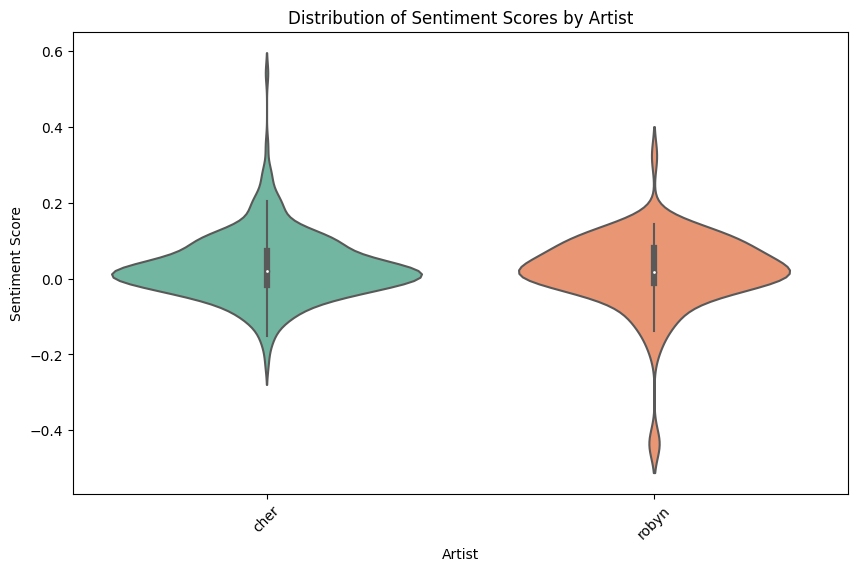

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.violinplot(x='Artist', y='Bing_Liu_Score', data=df, palette='Set2')
plt.title('Distribution of Sentiment Scores by Artist')
plt.xlabel('Artist')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()


## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/).

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [17]:
# your code here

positive_emojis = {
    '😂': 1,
    '😍': 1,
    '😭': 1,
    '💘': 1,
    '💞': 1,
    '🌈': 1,
    '🔴': 1,
    '🎀': 1,
    '🛍': 1,
    '🌺': 1

}

negative_emojis ={
    '😡':-1,
    '🤮':-1,
    '👿':-1,
    '👎🏼':-1,
    '🙅‍♀️':-1,
    '💔':-1,
    '❌':-1,
    '👊':-1,
    '🥀':-1,
    '🧟‍♀️':-1
}


In [21]:
def calculate_emoji_score(text):
    if isinstance(text, str):
        emoji_score = 0
        for char in text:
            if char in positive_emojis:
                emoji_score += positive_emojis[char]
            elif char in negative_emojis:
                emoji_score += negative_emojis[char]
        return emoji_score
    else:
        return 0  # Return 0 for non-string values

In [24]:
twitter_df['Emoji_Score'] = twitter_df['description'].apply(calculate_emoji_score)

# Calculate the average emoji score by artist
average_emoji_score_by_artist = twitter_df.groupby('Artist')['Emoji_Score'].mean()

print(average_emoji_score_by_artist)

Artist
cher     0.015875
robyn    0.014588
Name: Emoji_Score, dtype: float64


In [25]:
def count_emoji_occurrences(text, emojis):
    emoji_counts = {emoji: 0 for emoji in emojis.keys()}
    if isinstance(text, str):
        for char in text:
            if char in emojis:
                emoji_counts[char] += 1
    return emoji_counts

In [26]:
# Calculate positive and negative emoji occurrences for each artist
twitter_df['Positive_Emoji_Counts'] = twitter_df['description'].apply(lambda x: count_emoji_occurrences(x, positive_emojis))
twitter_df['Negative_Emoji_Counts'] = twitter_df['description'].apply(lambda x: count_emoji_occurrences(x, negative_emojis))


In [27]:
def get_max_key(dictionary):
    if dictionary:
        return max(dictionary, key=dictionary.get)
    else:
        return None

most_popular_positive_emojis = twitter_df.groupby('Artist')['Positive_Emoji_Counts'].apply(
    lambda x: get_max_key(x.iloc[0]))

most_popular_negative_emojis = twitter_df.groupby('Artist')['Negative_Emoji_Counts'].apply(
    lambda x: get_max_key(x.iloc[0]))

# Print or display the results
print("Most Popular Positive Emojis by Artist:")
print(most_popular_positive_emojis)
print("\nMost Popular Negative Emojis by Artist:")
print(most_popular_negative_emojis)

Most Popular Positive Emojis by Artist:
Artist
cher     😂
robyn    😂
Name: Positive_Emoji_Counts, dtype: object

Most Popular Negative Emojis by Artist:
Artist
cher     😡
robyn    😡
Name: Negative_Emoji_Counts, dtype: object


Q: What is the average sentiment of your two artists?

A: The avg sentiment of the emoji score for each artist. I don't know if this is really reliable as the emojis were difficult to deal with. Knowing which ones could be negative was a bit more challenging.

cher     0.015875,

robyn    0.014588

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji?

A: Both artist have the same positive and negative emoji. It must be due to the limited emojis in the positive and negative dictionaries. I used the most common ones I could find based on the emoji tracker. (postive) 😂, (negative)😡

